In [7]:
import os

path = "run4"
dest = "filter"
dir_list = os.listdir(path)
for file in dir_list:
    with open (os.path.join(path,file), "r") as fileHandler:
        listOfLines = fileHandler.readlines()
    for idx, line in enumerate(listOfLines):
        if idx<=2 or "attribute" in line or "torch" in line or "avg:" in line or "std:" in line or "====" in line:
            with open(os.path.join(dest,file), 'a+') as the_file:
                the_file.write(line)

In [ ]:
import os
import pickle

from matplotlib import pyplot as plt
import numpy as np


def set_box_color(bp, color):
    plt.setp(bp["boxes"], color=color)
    plt.setp(bp["whiskers"], color=color)
    plt.setp(bp["caps"], color=color)
    plt.setp(bp["medians"], color=color)


def find_attr(attributes, keywords):
    for key in keywords:
        for attr in attributes:
            if key in attr[3]:
                # print("found", attr[3])
                return True

    return False


counter = 0
trans = {
    "AGE": "age",
    "PTGENDER": "gender",
    "PTEDUCAT": "education",
    "PTETHCAT": "ethnicity",
    "PTRACCAT": "race",
    "PTMARRY": "marriage",
}
modes = ["disc"]
models = ["logistic", "mlp4", "mlp6"]
dataset_splits = [0, 1]
for model in models:
    for mode in modes:
        for dataset_split in dataset_splits:
            for measure in ["FPR", "FNR"]:
                save_path = (
                    f"run6/model_{model}_split_{dataset_split}_log_{mode}"
                )
                with open(save_path + ".pkl", "rb") as f:
                    attrs_metrics = pickle.load(f)
                plots = dict()
                for attr, metrics in attrs_metrics.items():
                    if find_attr(attr, ["PTEDUCAT", "AGE"]):
                        continue
                    if len(attr) not in plots:
                        plots[len(attr)] = []
                    plots[len(attr)].append((attr, metrics))

                for leng, group in plots.items():
                    attr_tmp, std_acc_tmp, cer_acc_tmp, pgd_acc_tmp = [], [], [], []
                    for attr, metrics in group:
                        attr_ = str([tmp[3] for tmp in attr])

                        for k, v in trans.items():
                            attr_ = attr_.replace(k, v)

                        attr_tmp.append(attr_.replace("[", "").replace("]", "").replace("'", ""))
                        std_acc_tmp.append(metrics["clean"][measure])
                        cer_acc_tmp.append(metrics["verify"][measure])
                        pgd_acc_tmp.append(metrics["pgd"][measure])
                    plt.rcParams.update({'font.size': 22, 'font.family':'serif', })
                    fig = plt.figure(figsize=(16, 8))
                    labels = attr_tmp
                    x = np.arange(len(labels))
                    width = 0.25
                    width_ = 0.2
                    c1 = plt.boxplot(
                        std_acc_tmp,
                        positions=x - width/2,
                        sym="",
                        widths=width_,
                    )
                    c2 = plt.boxplot(
                        cer_acc_tmp,
                        positions=x+width/2,
                        sym="",
                        widths=width_,
                    )
                    # c3 = plt.boxplot(
                    #     pgd_acc_tmp,
                    #     positions=x + width,
                    #     sym="",
                    #     widths=width_,
                    # )
                    colors = [
                        "#D7191C",
                        "#2C7BB6",
                    ]
                    boxes = [c1, c2]
                    for c_, color in zip(boxes, colors):
                        set_box_color(c_, color)  # colors are from http://colorbrewer2.org/
                    for c_, color in zip(["clean", "certified"], colors):
                        plt.plot([], c=color, label=c_)
                    plt.legend()
                    plt.ylabel(f"{measure}")
                    plt.xlabel("Attribute Combinations")
                    classes = f"{'NL=0, MCI=1' if dataset_split==0 else 'MCI=0, Dementia=1'}"
                    title = f"{model}_model, {classes}, {'discrete' if mode=='disc' else 'continuous'}, {leng} combinations, {measure}"
                    plt.title(title)
                    ticks = labels
                    plt.xticks(range(0, len(ticks)), ticks)
                    min = np.min(np.concatenate([std_acc_tmp, cer_acc_tmp]))
                    max = np.max(np.concatenate([std_acc_tmp, cer_acc_tmp]))
                    min = 0.0 if min - 0.05 <= 0.0 else min
                    max = 1.0 if max + 0.05 >= 1.0 else max
                    plt.yticks(np.arange(min, max + 0.01, 0.05))
                    if len(labels) >=3 and len(labels[1])>=len("gender, race"):
                        fig.autofmt_xdate(rotation=27.5)
                    # font = {'family' : 'normal',
                    #         'weight' : 'bold',
                    #         'size'   : 22}
                    # matplotlib.rc('font', **font)
                    
                    plt.savefig(os.path.join("plots", f"{title.replace(', ','_')}.png"))
                    plt.show()
                    print(counter + 1)
                    plt.close()
                    counter += 1


In [4]:
import numpy as np
np.arange(0.0,1.1,0.5)

array([0. , 0.5, 1. ])

In [12]:
np.min(np.concatenate([std_acc_tmp, pgd_acc_tmp, cer_acc_tmp]))

0.0

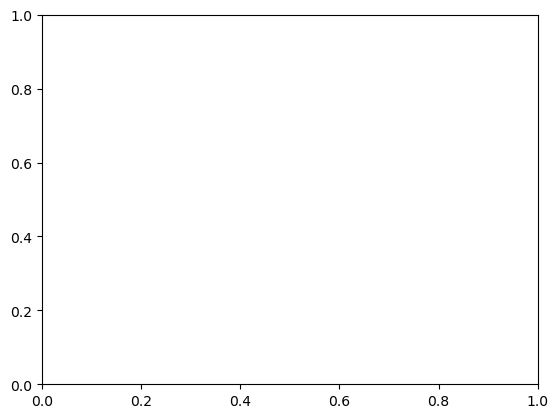

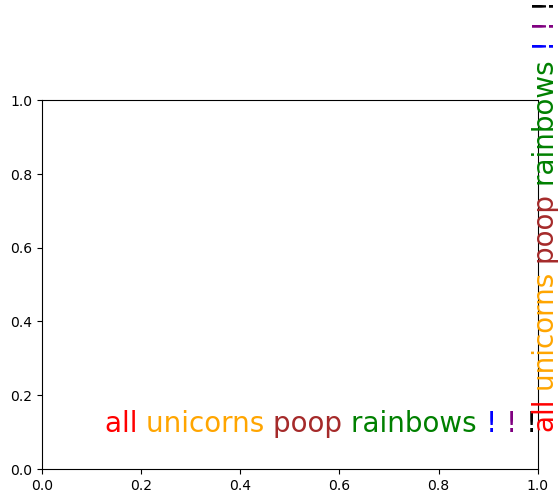

In [1]:
import matplotlib.pyplot as plt
from matplotlib import transforms

def rainbow_text(x,y,ls,lc,**kw):
    """
    Take a list of strings ``ls`` and colors ``lc`` and place them next to each
    other, with text ls[i] being shown in color lc[i].

    This example shows how to do both vertical and horizontal text, and will
    pass all keyword arguments to plt.text, so you can set the font size,
    family, etc.
    """
    t = plt.gca().transData
    fig = plt.gcf()
    plt.show()

    #horizontal version
    for s,c in zip(ls,lc):
        text = plt.text(x,y,s+" ",color=c, transform=t, **kw)
        text.draw(fig.canvas.get_renderer())
        ex = text.get_window_extent()
        t = transforms.offset_copy(text._transform, x=ex.width, units='dots')

    #vertical version
    for s,c in zip(ls,lc):
        text = plt.text(x,y,s+" ",color=c, transform=t,
                rotation=90,va='bottom',ha='center',**kw)
        text.draw(fig.canvas.get_renderer())
        ex = text.get_window_extent()
        t = transforms.offset_copy(text._transform, y=ex.height, units='dots')


plt.figure()
rainbow_text(0.05,0.05,"all unicorns poop rainbows ! ! !".split(), 
        ['red', 'orange', 'brown', 'green', 'blue', 'purple', 'black'],
        size=20)